In this code we take Oct 1st, 2021 - Dec31st 2024 as training and Jan 1st, 2025 - Aug 21st, 2025 as test. So we are doing a "forward regression" (FR). Can't use 'year' as feature due to overfitting, so we do detrending (DT) using year first.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib

In [2]:
#load data/AllWeathDTypes_NWPP_10yrs.csv as a dataframe
DFX = pd.read_csv("../data/FE_WFC_R-NWPP_H-7_22Aug25-latest.csv")
DFX1= pd.read_csv("../data/FE_ALLWeath_regNWPP_20210901-20250929.csv")
DFY = pd.read_csv("../data/RTLoad_MIDC+NW_1Sep21-latest.csv").drop(['objectid','yes_objectid','iso'], axis=1)
DFY['datetime'] = pd.to_datetime(DFY['datetime'])
DFX1['datetime'] = pd.to_datetime(DFX1['datetime'])
# DFY['datetime'] = DFY['datetime'] - pd.Timedelta(hours=7)
DFX['datetime'] = pd.to_datetime(DFX['datetime'])
DFX['model_date'] = pd.to_datetime(DFX['model_date']).dt.date


--- Processing model date: 2025-09-18 ---
Making predictions for 7 zones

--- Processing model date: 2025-09-19 ---
No data available for model date 2025-09-19

--- Processing model date: 2025-09-20 ---
Making predictions for 7 zones

--- Processing model date: 2025-09-21 ---
Making predictions for 7 zones

--- Processing model date: 2025-09-22 ---
Making predictions for 7 zones

--- Processing model date: 2025-09-23 ---
Making predictions for 7 zones

--- Processing model date: 2025-09-24 ---
No data available for model date 2025-09-24

--- Processing model date: 2025-09-25 ---
Making predictions for 7 zones

--- Processing model date: 2025-09-26 ---
No data available for model date 2025-09-26


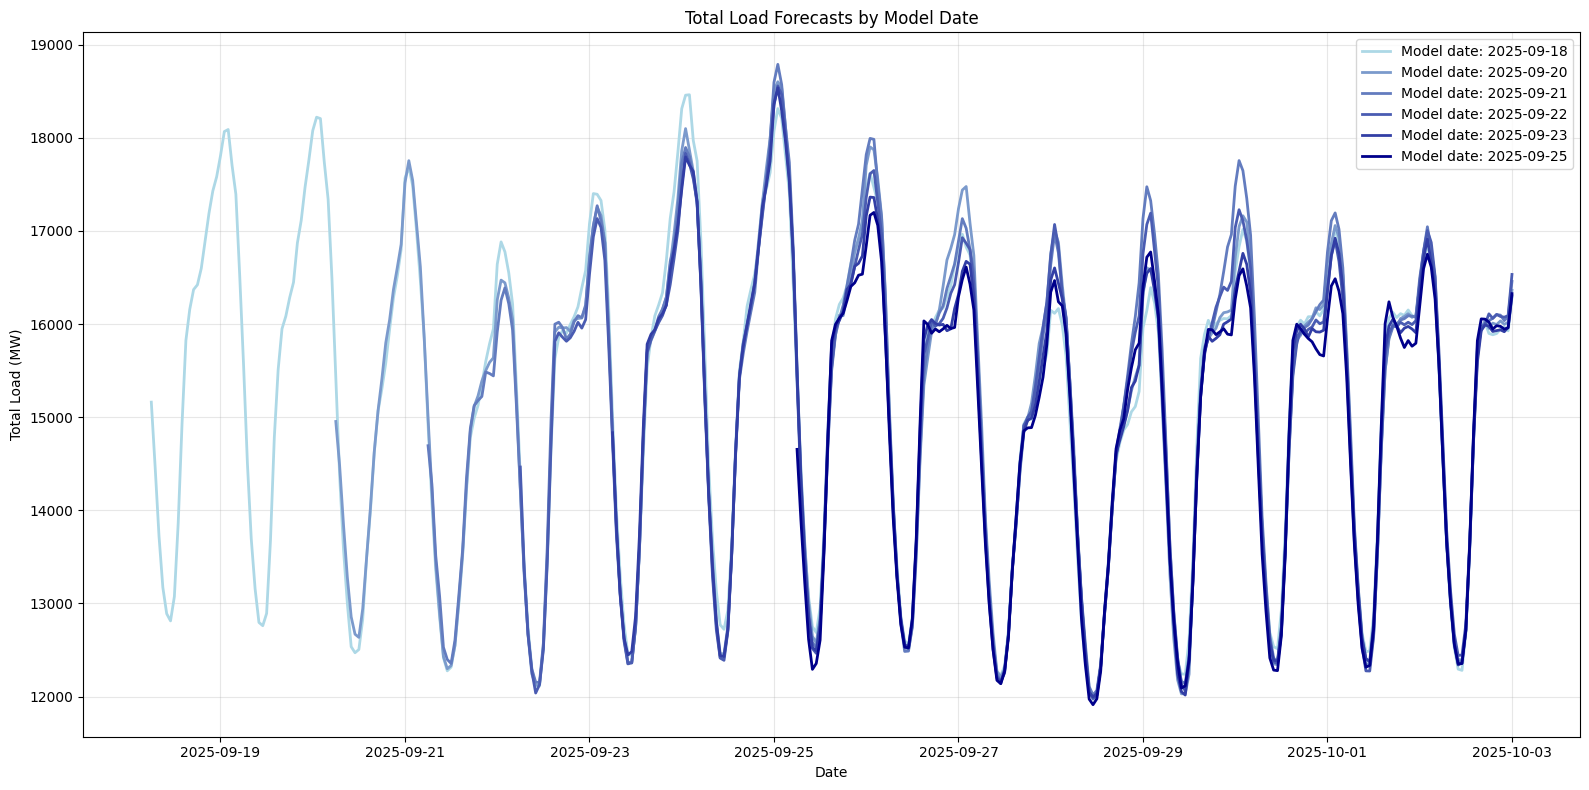


Daily Average Total Load Forecasts (MW) by Days Ahead


Days Ahead,0,1,2,3,4,5,6,7,Average
Model Date,,,,,,,,,
2025-09-18,15253.956703,15787.694967,15266.454918,14797.015933,15026.563245,15516.170915,15884.395784,15743.551765,15409.475529
2025-09-20,14553.344193,14817.843947,14928.098347,15331.802644,15692.598111,15768.501811,15480.441126,14836.546119,15176.147037
2025-09-21,14070.336479,14913.557913,15332.060911,15625.691480,15803.675569,15454.667985,14717.774696,14557.482174,15059.405901
2025-09-22,14488.548757,15249.554456,15607.722112,15687.933551,15364.439425,14694.196684,14518.876623,15081.959737,15086.653918
2025-09-23,14846.952483,15620.435811,15688.364330,15294.111356,14566.293158,14377.251269,14851.982360,15049.060307,15036.806384
2025-09-25,14781.740050,15240.069967,14497.511721,14373.354266,14892.562195,14943.702828,14988.271993,15060.824755,14847.254722


In [9]:
#One model for each zone

import xgboost as xgb
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from datetime import datetime
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
import joblib
from matplotlib.colors import LinearSegmentedColormap

model_dates = pd.date_range(pd.to_datetime('2025-09-18'), pd.Timestamp.now().date()).date.tolist()
date_range = (pd.to_datetime('2025-09-18'), pd.to_datetime('2025-10-03'))
folder = f"../ML_results/LinReg+XGBRegressor_perZone/20250924_2"

# Dictionary to store total load predictions for each model date
all_predictions = {}

for model_date in model_dates:
    print(f"\n--- Processing model date: {model_date} ---")
    
    # Filter data for this model_date within the date range
    model_df = DFX[(DFX['model_date'] == model_date) & 
                   (DFX['datetime'] >= date_range[0]) & 
                   (DFX['datetime'] <= date_range[1])].copy()
    
    if model_df.empty:
        print(f"No data available for model date {model_date}")
        continue
    
    model_df = model_df.drop('model_date', axis=1).reset_index(drop=True)
    
    # Get unique names from DFY
    unique_names = sorted([name for name in DFY['name'].unique() if name != 'AVRN'])
    print(f"Making predictions for {len(unique_names)} zones")

    # Process each zone and make predictions
    predictions_df = pd.DataFrame()

    for name in unique_names:
        try:
            model_path = f"{folder}/models/{name}_xgb_model.pkl"
            model = joblib.load(model_path)
            
            # Get unique stations from model_df
            stations = model_df['station_name'].unique()
            
            # Create station dataframes
            station_dfs = []
            for station in stations:
                station_data = model_df[model_df['station_name'] == station].copy()
                station_data = station_data.set_index('datetime')
                station_data = station_data.drop('station_name', axis=1)
                station_data = station_data.rename(columns={col: f"{col}_{station}" for col in station_data.columns})
                station_dfs.append(station_data)
            dfX = pd.concat(station_dfs, axis=1).reset_index()
            
            # Extract date and time components
            dfX['year'] = dfX['datetime'].dt.year
            dfX['month'] = dfX['datetime'].dt.month
            dfX['date'] = dfX['datetime'].dt.day
            dfX['day'] = dfX['datetime'].dt.dayofweek
            dfX['time'] = dfX['datetime'].dt.hour
            
            # Load the trend model
            trend_model_path = f"{folder}/models/{name}_trend_model.pkl"
            trend_model = joblib.load(trend_model_path)
            
            # For detrending, we need to estimate a baseline
            X_year = dfX[['year']].astype(float)
            
            # Use the loaded trend model to predict the trend
            y_trend = trend_model.predict(X_year)
        
            # Prepare features for the XGBoost model
            exclude_cols = ['Predicted Load', 'set', 'datetime']
            features = [col for col in dfX.columns if col not in exclude_cols]
            
            X_pred = dfX[features]
            
            # Handle missing values
            X_pred = X_pred.fillna(X_pred.median())
            
            # Predict residuals and add trend
            residuals_pred = model.predict(X_pred)
            load_pred = residuals_pred + y_trend
            
            # Create prediction dataframe
            zone_pred_df = pd.DataFrame({
                'datetime': dfX['datetime'],
                'name': name,
                'predicted_load': load_pred
            })
            
            # Append to main predictions dataframe
            predictions_df = pd.concat([predictions_df, zone_pred_df])
            
        except Exception as e:
            print(f"Error making predictions for {name}: {e}")

    if not predictions_df.empty:
        # Group by datetime and sum predicted load across all zones
        daily_total_forecast = predictions_df.groupby('datetime')['predicted_load'].sum().reset_index()
        
        # Store total predictions for this model date
        all_predictions[model_date] = daily_total_forecast

# Create a plot comparing total load predictions for different model dates
if all_predictions:
    plt.figure(figsize=(16, 8))
    
    # Create colormap from light to dark
    cmap = LinearSegmentedColormap.from_list("", ["lightblue", "darkblue"])
    
    # Convert model dates to ordinals for color mapping
    date_ordinals = [pd.Timestamp(d).toordinal() for d in all_predictions.keys()]
    min_date = min(date_ordinals)
    max_date = max(date_ordinals)
    color_norm = [(d - min_date) / (max_date - min_date) if max_date > min_date else 0.5 for d in date_ordinals]
    
    # Plot each model date's predictions with color based on recency
    for (model_date, data), color_val in zip(all_predictions.items(), color_norm):
        color = cmap(color_val)
        plt.plot(data['datetime'], data['predicted_load'], '-', 
                 color=color, linewidth=2, 
                 label=f'Model date: {model_date.strftime("%Y-%m-%d")}')
    
    plt.title('Total Load Forecasts by Model Date')
    plt.xlabel('Date')
    plt.ylabel('Total Load (MW)')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
else:
    print("No predictions were generated for any model dates")

# Create a table with daily average load forecasts by forecast horizon (days ahead)
# Get all unique prediction dates across all model dates
all_pred_dates = set()
for model_date, prediction_df in all_predictions.items():
    dates = prediction_df['datetime'].dt.date.unique()
    all_pred_dates.update(dates)

all_pred_dates = sorted(list(all_pred_dates))

# Create the DataFrame with forecast horizons (0-7 days ahead) as columns
days_ahead = 8
daily_avg_loads = pd.DataFrame(index=sorted(all_predictions.keys()), columns=range(days_ahead))
daily_avg_loads.index.name = 'Model Date'
daily_avg_loads.columns.name = 'Days Ahead'

# Fill the DataFrame with average daily loads
for model_date, prediction_df in all_predictions.items():
    # Add date column (without time)
    prediction_df['date'] = prediction_df['datetime'].dt.date
    
    # Calculate daily averages
    daily_avgs = prediction_df.groupby('date')['predicted_load'].mean()
    
    # Add to the DataFrame based on day difference
    for date, avg_load in daily_avgs.items():
        day_diff = (pd.Timestamp(date) - pd.Timestamp(model_date)).days
        if 0 <= day_diff < days_ahead:  # Only include forecasts 0-7 days ahead
            daily_avg_loads.loc[model_date, day_diff] = avg_load

# Format the output and add average column
daily_avg_loads = daily_avg_loads.round(2)  # Round to 2 decimal places
daily_avg_loads['Average'] = daily_avg_loads.mean(axis=1).round(2)  # Add average column

# Define a function to color cells based on comparison to column average
def color_scale(val, col_avg):
    if pd.isna(val):
        return ''
    # Determine the intensity of color based on distance from average
    max_diff = col_avg * 0.2  # 20% difference for max color intensity
    ratio = min(abs(val - col_avg) / max_diff, 1.0) if max_diff > 0 else 0
    
    if val > col_avg:
        # Red for higher values
        return f'background-color: rgba(255, 0, 0, {ratio*0.5})'
    else:
        # Blue for lower values
        return f'background-color: rgba(0,0, 255, {ratio*0.5})'

# Calculate column averages
col_avgs = daily_avg_loads.mean()

# Apply conditional formatting - fix the index issue by checking column name
styled_df = daily_avg_loads.style.apply(
    lambda x: [color_scale(v, col_avgs[i]) if i in col_avgs else '' 
               for i, v in enumerate(x)], 
    axis=1
)

# Display the table with styling
print("\nDaily Average Total Load Forecasts (MW) by Days Ahead")
display(styled_df)


In [14]:
random_date = predictions_df.loc[0]['datetime']
predictions_df[predictions_df['datetime'] == random_date]

ValueError: Can only compare identically-labeled Series objects

In [18]:
 predictions_df.loc[0]

,datetime,name,predicted_load
0,2025-09-25 06:00:00,Avista Corporation,978.729823
0,2025-09-25 06:00:00,BPA,5881.382679
0,2025-09-25 06:00:00,"City of Tacoma, Department of Public Utilities",406.248834
0,2025-09-25 06:00:00,Idaho Power Company,1893.900515
0,2025-09-25 06:00:00,Portland General Electric Company,2321.406888
0,2025-09-25 06:00:00,"Puget Sound Energy, Inc.",2310.581961
0,2025-09-25 06:00:00,Seattle City Light,862.210950


In [12]:
prediction_df

,datetime,predicted_load,date
0,2025-09-25 06:00:00,14654.461650,2025-09-25
1,2025-09-25 07:00:00,13898.889529,2025-09-25
2,2025-09-25 08:00:00,13225.806598,2025-09-25
3,2025-09-25 09:00:00,12615.449740,2025-09-25
4,2025-09-25 10:00:00,12292.178149,2025-09-25
...,...,...,...
182,2025-10-02 20:00:00,15982.543174,2025-10-02
183,2025-10-02 21:00:00,15975.876212,2025-10-02
184,2025-10-02 22:00:00,15945.941504,2025-10-02
185,2025-10-02 23:00:00,15959.903502,2025-10-02


In [49]:
# Load the 10-year historical data
historical_data = pd.read_csv("../data/RTLoad_MIDC+NW_10yrs.csv").drop(['objectid','yes_objectid','iso'], axis=1).rename(columns={'avgvalue': 'load'})
 # Filter for last 10 years
historical_data['datetime'] = pd.to_datetime(historical_data['datetime'])
historical_data = historical_data[(historical_data['datetime'].dt.year >= 2015)&(historical_data['datetime'].dt.year <= 2024)]
# Extract month and day for matching
historical_data['month_day'] = historical_data['datetime'].dt.strftime('%m-%d')

# Group by name first, then by month_day, to get average load by utility and date
avg_hist_by_zone_date = historical_data.groupby(['name', 'month_day'])['load'].mean().reset_index()

# Calculate total historical average load by month-day (across all utilities)
avg_historical_by_date = avg_hist_by_zone_date.groupby('month_day')['load'].sum()

# Create a new DataFrame for differences with the same structure as daily_avg_loads
load_differences = pd.DataFrame(index=daily_avg_loads.index, columns=range(days_ahead))
load_differences.index.name = 'Model Date'
load_differences.columns.name = 'Days Ahead'

# Calculate differences between forecasted and historical loads
for model_date in load_differences.index:
    for days_ahead_val in range(days_ahead):
        if pd.notna(daily_avg_loads.loc[model_date, days_ahead_val]):
            # Calculate the forecast date
            forecast_date = pd.Timestamp(model_date) + pd.Timedelta(days=days_ahead_val)
            month_day = forecast_date.strftime('%m-%d')
            
            # Get average historical load for this date
            if month_day in avg_historical_by_date.index:
                historical_avg = avg_historical_by_date[month_day]
                forecasted_avg = daily_avg_loads.loc[model_date, days_ahead_val]
                
                # Calculate and store the difference
                load_differences.loc[model_date, days_ahead_val] = forecasted_avg - historical_avg

# Format the output and add average column
load_differences = load_differences.round(2)
load_differences['Average'] = load_differences.mean(axis=1).round(2)

# Define a function to color cells based on comparison to column average
def color_scale(val, col_avg):
    if pd.isna(val):
        return ''
    # Determine the intensity of color based on distance from average
    max_diff = col_avg * 0.2 if col_avg != 0 else 1.0  # Avoid division by zero
    ratio = min(abs(val - col_avg) / max_diff, 1.0) if max_diff > 0 else 0
    
    if val > col_avg:
        # Red for higher values
        return f'background-color: rgba(255, 0, 0, {ratio*0.5})'
    else:
        # Blue for lower values
        return f'background-color: rgba(0,0, 255, {ratio*0.5})'

# Calculate column averages
col_avgs = load_differences.mean()

# Apply conditional formatting
styled_diff_df = load_differences.style.apply(
    lambda x: [color_scale(v, col_avgs[i]) if i in col_avgs and pd.notna(v) else '' 
               for i, v in enumerate(x)], 
    axis=1
)

# Display the tables
print("\nDifference Between Forecasted and Historical Average Load (MW) by Days Ahead")
display(styled_diff_df)

# Set n to 10 for last n years
n_years = 1

# Create a table of average historical loads by date, including last n years' daily averages
hist_load_data = []
unique_forecast_dates = set()

for model_date in daily_avg_loads.index:
    for days_ahead_val in range(days_ahead):
        if pd.notna(daily_avg_loads.loc[model_date, days_ahead_val]):
            forecast_date = pd.Timestamp(model_date) + pd.Timedelta(days=days_ahead_val)
            unique_forecast_dates.add(forecast_date.date())

for date in sorted(unique_forecast_dates):
    month_day = date.strftime('%m-%d')
    # Get all years available for this month_day
    available_years = sorted(historical_data['datetime'].dt.year.unique())
    last_n_years = available_years[-n_years:] if len(available_years) >= n_years else available_years
    avg_last_years = []
    for yr in last_n_years:
        mask = (historical_data['datetime'].dt.year == yr) & (historical_data['month_day'] == month_day)
        avg_load = historical_data.loc[mask, 'load'].mean() if mask.any() else np.nan
        avg_last_years.append(round(avg_load, 2) if not np.isnan(avg_load) else np.nan)
    # Historical average over all years
    hist_avg = round(avg_historical_by_date[month_day], 2) if month_day in avg_historical_by_date.index else np.nan
    row = {
        'Date': date,
        'Average Historical Load (MW)': hist_avg,
    }
    for i, yr in enumerate(last_n_years):
        row[f'Load {yr}'] = avg_last_years[i]
    hist_load_data.append(row)

hist_load_table = pd.DataFrame(hist_load_data)

# Display historical load table
print(f"\nAverage Historical Load by Date (with last {n_years} years):")
display(hist_load_table)


Difference Between Forecasted and Historical Average Load (MW) by Days Ahead


Days Ahead,0,1,2,3,4,5,6,7,Average
Model Date,,,,,,,,,
2025-09-18,-1144.383453,-639.124521,-1216.287383,-1586.696556,-1224.323423,-740.219694,-439.797635,-759.875385,-968.838506
2025-09-20,-1929.398107,-1565.868542,-1322.788321,-924.587965,-631.595309,-734.925339,-1085.956101,-1882.394334,-1259.689252
2025-09-21,-2313.376010,-1337.328755,-924.329697,-698.501939,-699.751581,-1111.729243,-2001.165757,-2082.223084,-1396.050758
2025-09-22,-1762.337911,-1006.836153,-716.471307,-815.493598,-1201.957803,-2024.743769,-2120.828634,-1417.394998,-1383.258022
2025-09-23,-1409.438125,-703.757608,-815.062820,-1272.285872,-2152.647295,-2262.453989,-1647.372374,-1385.603626,-1456.077714
2025-09-25,-1721.687099,-1326.327260,-2221.428732,-2266.350992,-1606.792539,-1490.961105,-1305.702161,-1362.306561,-1662.694556



Average Historical Load by Date (with last 1 years):


,Date,Average Historical Load (MW),Load 2024
0,2025-09-18,16398.34,1909.76
1,2025-09-19,16426.82,1920.26
2,2025-09-20,16482.74,1913.12
3,2025-09-21,16383.71,1805.37
4,2025-09-22,16250.89,1766.37
5,2025-09-23,16256.39,1904.13
6,2025-09-24,16324.19,2012.95
7,2025-09-25,16503.43,2063.87
8,2025-09-26,16566.40,1944.12
9,2025-09-27,16718.94,1919.78


C:\Users\kumar\AppData\Local\Temp\ipykernel_2372\611945452.py:41: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range_2024 = pd.date_range(start=start_date_2024, end=end_date_2024, freq='H')


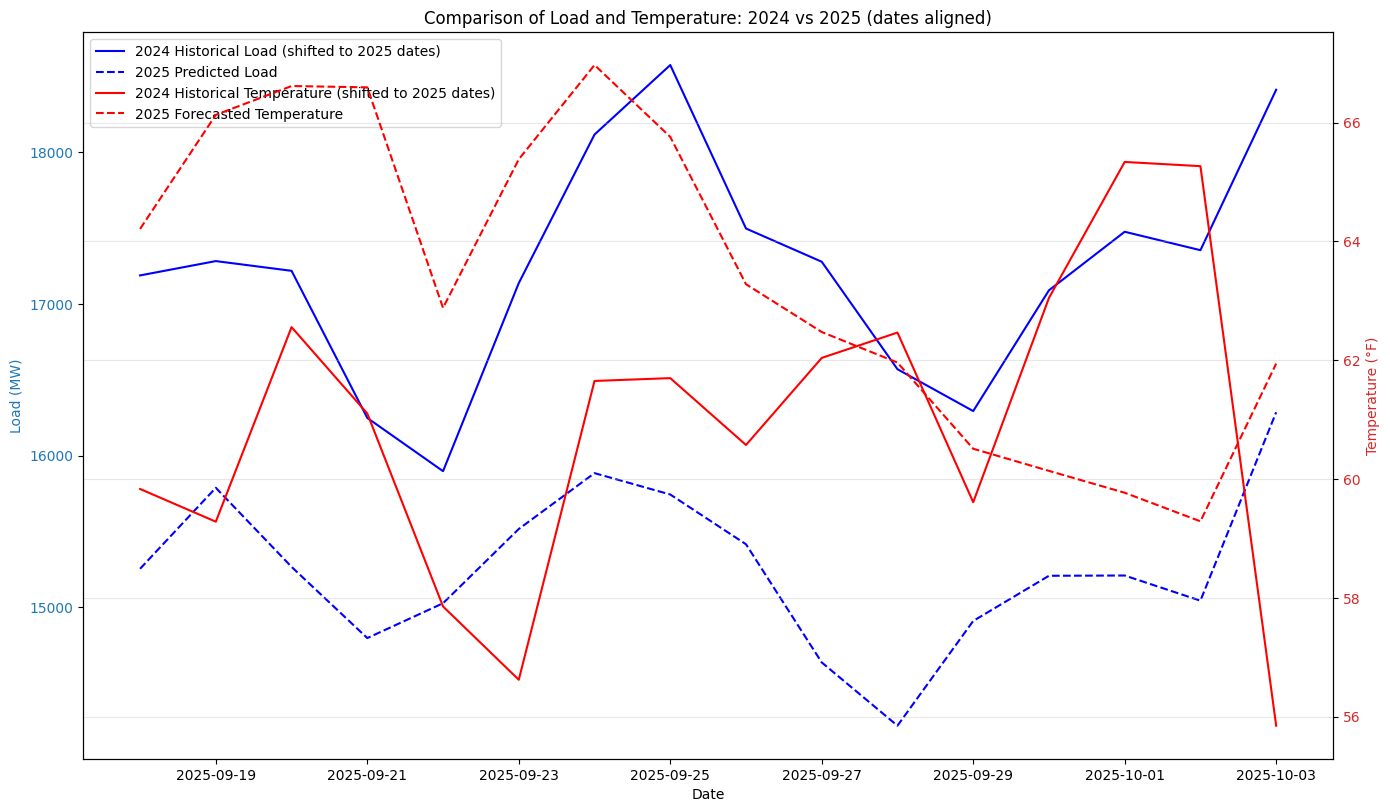

In [51]:
# Extract the date range for comparison
start_date = pd.to_datetime('2025-09-18')
end_date = pd.to_datetime('2025-10-03')

# Get the first model date to use for weather forecasts
first_model_date = model_dates[0]  # This should be 2025-09-18

# Create equivalent date ranges for 2024
start_date_2024 = start_date.replace(year=2024)
end_date_2024 = end_date.replace(year=2024)

# Get historical load data for 2024
hist_load_2024 = historical_data[
    (historical_data['datetime'] >= start_date_2024) & 
    (historical_data['datetime'] <= end_date_2024)
].copy()

# Aggregate historical load by datetime (sum across all zones)
hist_load_2024_agg = hist_load_2024.groupby('datetime')['load'].sum().reset_index()
hist_load_2024_agg['date'] = hist_load_2024_agg['datetime'].dt.date

# Get the forecasted load for 2025 from the first model date
if first_model_date in all_predictions:
    forecast_load_2025 = all_predictions[first_model_date].copy()
    forecast_load_2025['date'] = forecast_load_2025['datetime'].dt.date
else:
    print(f"No predictions available for model date {first_model_date}")

# Get temperature data
# For 2024 - Extract from historical weather data if available, or use proxy
# For 2025 - Use the forecasted temperature from DFX for the first model date
temp_data_2025 = DFX[DFX['model_date'] == first_model_date].copy()

# If we have NWPP station data, use that as representative for the region, otherwise use average of all stations
temp_data_2025_agg = temp_data_2025.groupby('datetime')['temperature'].mean().reset_index()
temp_data_2025_agg['date'] = temp_data_2025_agg['datetime'].dt.date

# Try to get historical temperature data for 2024
# This is a placeholder - you'll need to adjust based on your actual historical weather data source
# For now, we'll create a synthetic temperature dataset for illustration
date_range_2024 = pd.date_range(start=start_date_2024, end=end_date_2024, freq='H')
temp_data_2024 = pd.DataFrame({
    'datetime': date_range_2024,
    'temperature': np.random.normal(60, 10, size=len(date_range_2024))  # Placeholder
})
temp_data_2024['date'] = temp_data_2024['datetime'].dt.date

# Create daily aggregations for cleaner plotting
temp_data_2024_daily = temp_data_2024.groupby('date')['temperature'].mean().reset_index()
temp_data_2025_daily = temp_data_2025_agg.groupby('date')['temperature'].mean().reset_index()
hist_load_2024_daily = hist_load_2024_agg.groupby('date')['load'].mean().reset_index()
forecast_load_2025_daily = forecast_load_2025.groupby('date')['predicted_load'].mean().reset_index()

# Create adjusted dates for 2024 data by shifting years to 2025 for comparison
temp_data_2024_daily['date_adjusted'] = temp_data_2024_daily['date'].apply(
    lambda x: pd.Timestamp(x).replace(year=2025).date()
)
hist_load_2024_daily['date_adjusted'] = hist_load_2024_daily['date'].apply(
    lambda x: pd.Timestamp(x).replace(year=2025).date()
)

# Create the plot
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot loads on primary y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Load (MW)', color='tab:blue')
ax1.plot(hist_load_2024_daily['date_adjusted'], hist_load_2024_daily['load'], 
         'b-', label='2024 Historical Load (shifted to 2025 dates)')
ax1.plot(forecast_load_2025_daily['date'], forecast_load_2025_daily['predicted_load'], 
         'b--', label='2025 Predicted Load')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create second y-axis for temperature
ax2 = ax1.twinx()
ax2.set_ylabel('Temperature (°F)', color='tab:red')
ax2.plot(temp_data_2024_daily['date_adjusted'], temp_data_2024_daily['temperature'], 
         'r-', label='2024 Historical Temperature (shifted to 2025 dates)')
ax2.plot(temp_data_2025_daily['date'], temp_data_2025_daily['temperature'], 
         'r--', label='2025 Forecasted Temperature')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Create a combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

fig.tight_layout()
plt.title('Comparison of Load and Temperature: 2024 vs 2025 (dates aligned)')
plt.grid(True, alpha=0.3)
plt.show()

In [31]:
DFY.head()

,datetime,name,avgvalue,timezone
0,2021-10-13 15:00:00,BPA,6994.750000,America/Los_Angeles
1,2021-10-13 16:00:00,BPA,7058.500000,America/Los_Angeles
2,2021-10-13 17:00:00,BPA,6884.166667,America/Los_Angeles
3,2021-10-13 18:00:00,BPA,6736.500000,America/Los_Angeles
4,2021-10-13 19:00:00,BPA,6573.166667,America/Los_Angeles


In [32]:
pd.read_csv("../data/RTLoad_MIDC+NW_10yrs.csv").drop(['objectid','yes_objectid','iso'], axis=1)

,datetime,name,avgvalue
0,2025-01-22 07:00:00,"Puget Sound Energy, Inc.",3735.0
1,2025-01-22 08:00:00,"Puget Sound Energy, Inc.",3517.0
2,2025-01-22 09:00:00,"Puget Sound Energy, Inc.",3403.0
3,2025-01-22 10:00:00,"Puget Sound Energy, Inc.",3356.0
4,2025-01-22 11:00:00,"Puget Sound Energy, Inc.",3358.0
...,...,...,...
533053,2017-12-08 04:00:00,Portland General Electric Company,3083.0
533054,2017-12-08 05:00:00,Portland General Electric Company,3024.0
533055,2017-12-08 06:00:00,Portland General Electric Company,2875.0
533056,2017-12-08 07:00:00,Portland General Electric Company,2634.0
